# CH05: Compressing Data via Dimensionality Reduction

In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), ".."))

## Unsupervised dimensionality reduction via principal component analysis

### Extracting the principal components step by step

In [2]:
# Load dataset

import pandas as pd
from sklearn import datasets

wine = datasets.load_wine()
df_wine = pd.DataFrame(wine.data, columns=wine.feature_names)
df_wine["target"] = wine.target

In [3]:
df_wine.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [4]:
# Split dataset into training and test subsets

from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, :-1], df_wine.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [5]:
# Standardize the features

from sklearn.preprocessing import StandardScaler

sc = StandardScaler().fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [6]:
# Construct covariance matrix & obtain eigenvectors/eigenvalues

import numpy as np

cov_mat = np.cov(X_train_std.T)

eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
eigen_vals

array([4.84274532, 2.41602459, 1.54845825, 0.96120438, 0.84166161,
       0.6620634 , 0.51828472, 0.34650377, 0.3131368 , 0.10754642,
       0.21357215, 0.15362835, 0.1808613 ])

In [7]:
eigen_vals/np.sum(eigen_vals)

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.00820609,
       0.01629614, 0.01172226, 0.01380021])

### Total and explained variance

In [8]:
tot = sum(eigen_vals)
var_exp = [ i/tot for i in sorted(eigen_vals, reverse=True) ]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([0.36951469, 0.55386396, 0.67201555, 0.74535807, 0.80957914,
       0.86009639, 0.89964293, 0.92608211, 0.9499753 , 0.96627144,
       0.98007165, 0.99179391, 1.        ])

In [9]:
import matplotlib.pyplot as plt

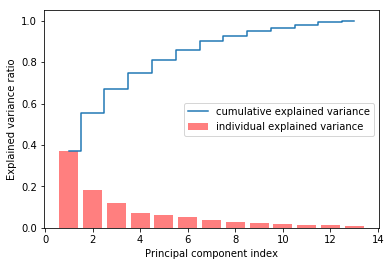

In [10]:
plt.bar(range(1, 14), var_exp, alpha=0.5, align="center", label="individual explained variance", color="red")
plt.step(range(1, 14), cum_var_exp, where="mid", label="cumulative explained variance")
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal component index")
plt.legend(loc="best")
plt.show()

### Feature transformation

In [11]:
eigen_pairs = [ (np.abs(val), vec) for val, vec in zip(eigen_vals, eigen_vecs) ]
eigen_pairs.sort(key=lambda x: x[0], reverse=True)

In [12]:
W = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

In [13]:
W

array([[-0.13724218,  0.24724326],
       [ 0.50303478,  0.16487119],
       [-0.13774873,  0.09615039],
       [-0.0032961 ,  0.56264669],
       [-0.29062523,  0.08953787],
       [ 0.29909685,  0.6270364 ],
       [ 0.07905293, -0.27400201],
       [-0.36817641, -0.01257758],
       [-0.39837702,  0.11045823],
       [-0.09448698,  0.02636524],
       [ 0.37463888, -0.1374056 ],
       [-0.12783451,  0.08064016],
       [ 0.26283426, -0.26676921]])

In [14]:
X_train_pca = X_train_std.dot(W)

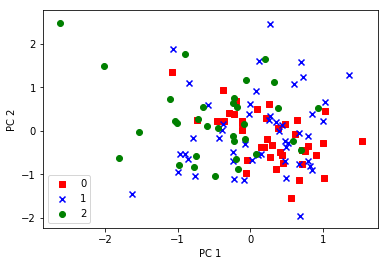

In [15]:
colors = ["r", "b", "g"]
markers = ["s", "x", "o"]

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], X_train_pca[y_train == l, 1], c=c, label=l, marker=m)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc="lower left")
plt.show()

## Principal component analysis in scikit-learn

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [17]:
pca = PCA(n_components=2).fit(X_train_std)

X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [18]:
lr = LogisticRegression()
lr.fit(X_train_pca, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

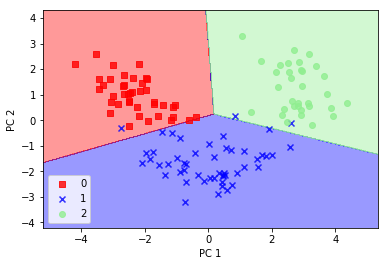

In [19]:
from utils import plot_decision_regions

plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc="lower left")
plt.show()

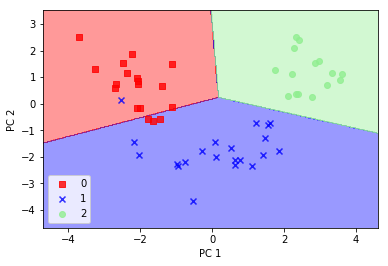

In [20]:
# Decision regions for test dataset

plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc="lower left")
plt.show()

In [21]:
# explained variance

pca = PCA(n_components=None).fit(X_train_std)
pca.explained_variance_ratio_ # compare with own implementation

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

In [22]:
pca.components_

array([[-1.37242175e-01,  2.47243265e-01, -2.54515927e-02,
         2.06945084e-01, -1.54365821e-01, -3.93769523e-01,
        -4.17351064e-01,  3.05728961e-01, -3.06683469e-01,
         7.55406578e-02, -3.26132628e-01, -3.68610222e-01,
        -2.96696514e-01],
       [ 5.03034778e-01,  1.64871190e-01,  2.44564761e-01,
        -1.13529045e-01,  2.89745182e-01,  5.08010391e-02,
        -2.28733792e-02,  9.04888470e-02,  8.35232677e-03,
         5.49775805e-01, -2.07164328e-01, -2.49025357e-01,
         3.80229423e-01],
       [-1.37748734e-01,  9.61503863e-02,  6.77775667e-01,
         6.25040550e-01,  1.96135481e-01,  1.40310572e-01,
         1.17053859e-01,  1.31217777e-01,  3.04309008e-02,
        -7.99299713e-02,  5.30591506e-02,  1.32391030e-01,
        -7.06502178e-02],
       [-3.29610003e-03,  5.62646692e-01, -1.08977111e-01,
         3.38187002e-02, -3.67511070e-01,  2.40245127e-01,
         1.87053299e-01, -2.29262234e-02,  4.96262330e-01,
         1.06482939e-01, -3.69053747e

## Supervised data compression via linear discriminant analysis

### Computing the scatter matrices

In [25]:
np.set_printoptions(precision=4)

In [29]:
mean_vecs = []
for label in range(0, 3):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))

In [30]:
mean_vecs

[array([ 0.9066, -0.3497,  0.3201, -0.7189,  0.5056,  0.8807,  0.9589,
        -0.5516,  0.5416,  0.2338,  0.5897,  0.6563,  1.2075]),
 array([-0.8749, -0.2848, -0.3735,  0.3157, -0.3848, -0.0433,  0.0635,
        -0.0946,  0.0703, -0.8286,  0.3144,  0.3608, -0.7253]),
 array([ 0.1992,  0.866 ,  0.1682,  0.4148, -0.0451, -1.0286, -1.2876,
         0.8287, -0.7795,  0.9649, -1.209 , -1.3622, -0.4013])]

In [36]:
d = 13 # number of features

S_W = np.zeros((d, d))
for label in range(0, 3):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter

In [37]:
S_W

array([[ 1.2448,  0.0967, -0.1276, -0.1105, -0.0726,  0.2374,  0.0753,
         0.0231,  0.1102,  0.4261,  0.1411, -0.0155,  0.1224],
       [ 0.0967,  2.2666,  0.1168,  0.3517, -0.2622, -0.0467, -0.0186,
         0.2194,  0.0187, -0.3939, -0.4167,  0.0787, -0.2492],
       [-0.1276,  0.1168,  2.6024,  1.6442,  0.5364,  0.3947,  0.3191,
         0.4553, -0.0353,  0.06  ,  0.167 ,  0.1987, -0.0081],
       [-0.1105,  0.3517,  1.6442,  2.1604,  0.325 ,  0.1535,  0.1222,
         0.273 , -0.0824, -0.068 ,  0.0336,  0.2548, -0.1201],
       [-0.0726, -0.2622,  0.5364,  0.325 ,  2.4397,  0.2384,  0.1433,
        -0.5166,  0.2566,  0.1445,  0.1777, -0.0058,  0.2509],
       [ 0.2374, -0.0467,  0.3947,  0.1535,  0.2384,  1.352 ,  0.6416,
        -0.0781,  0.7644,  0.4392,  0.0177,  0.4359,  0.1554],
       [ 0.0753, -0.0186,  0.3191,  0.1222,  0.1433,  0.6416,  0.6968,
        -0.2588,  0.5765,  0.3851, -0.0408,  0.2525,  0.0748],
       [ 0.0231,  0.2194,  0.4553,  0.273 , -0.5166, -0.0781, 

In [46]:
mean_overall = np.mean(X_train_std, axis=0).reshape(d, 1)

S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i,:].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

In [47]:
S_B

array([[ 73.2779,   5.1521,  29.3409, -37.8053,  35.3288,  27.8688,
         24.4037, -10.917 ,  11.9293,  51.2816,   0.2198,  -0.3445,
         73.9711],
       [  5.1521,  33.8209,   5.5342,  17.6688,  -3.0595, -41.4067,
        -51.4514,  32.9397, -31.0444,  36.0237, -47.4845, -53.4785,
        -18.4551],
       [ 29.3409,   5.5342,  12.1084, -13.0286,  13.5707,   6.6597,
          4.2554,  -0.8742,   1.4687,  23.8967,  -4.84  ,  -5.6837,
         27.1642],
       [-37.8053,  17.6688, -13.0286,  31.8532, -21.5944, -40.7237,
        -44.8903,  26.1101, -25.5242,  -6.7623, -28.9705, -32.2968,
        -52.5343],
       [ 35.3288,  -3.0595,  13.5707, -21.5944,  17.9512,  20.621 ,
         20.5742, -10.8479,  11.0338,  19.3529,   7.9757,   8.6902,
         39.5823],
       [ 27.8688, -41.4067,   6.6597, -40.7237,  20.621 ,  66.8061,
         78.1916, -47.8401,  45.861 , -22.5142,  61.6487,  69.1515,
         58.7931],
       [ 24.4037, -51.4514,   4.2554, -44.8903,  20.5742,  78.1916,
  

### Selecting linear discriminants for the new feature subspace

In [49]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [50]:
eigen_pairs = [ (np.abs(val), vec) for val, vec in zip(eigen_vals, eigen_vecs) ]
eigen_pairs.sort(key=lambda x: x[0], reverse=True)

In [53]:
for eigen_val, _ in eigen_pairs:
    print(eigen_val)

349.61780890599397
172.7615221897938
3.2408058667989877e-14
2.842170943040401e-14
2.525003131722881e-14
2.525003131722881e-14
1.7305705389846235e-14
1.7011368381160403e-14
1.4465403123928443e-14
1.4465403123928443e-14
4.462490677759783e-15
4.462490677759783e-15
3.7872569513332085e-15


In [54]:
tot = sum(eigen_vals)
var_exp = [ i/tot for i in sorted(eigen_vals, reverse=True) ]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([0.6693+0.0000e+00j, 1.    +0.0000e+00j, 1.    +0.0000e+00j,
       1.    +0.0000e+00j, 1.    +1.3886e-17j, 1.    +0.0000e+00j,
       1.    +4.9277e-18j, 1.    +0.0000e+00j, 1.    +0.0000e+00j,
       1.    +4.3027e-17j, 1.    +0.0000e+00j, 1.    +0.0000e+00j,
       1.    +0.0000e+00j])

/media/Data/Projects/PML/venv/lib/python3.6/site-packages/matplotlib/transforms.py:814: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/media/Data/Projects/PML/venv/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


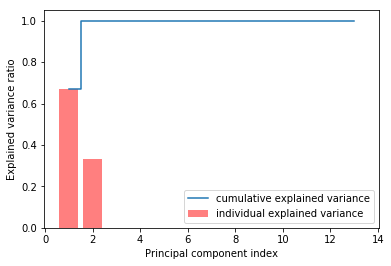

In [55]:
plt.bar(range(1, 14), var_exp, alpha=0.5, align="center", label="individual explained variance", color="red")
plt.step(range(1, 14), cum_var_exp, where="mid", label="cumulative explained variance")
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal component index")
plt.legend(loc="best")
plt.show()

In [56]:
W = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
W

array([[-0.2406, -0.0834],
       [-0.3537, -0.1577],
       [-0.0168,  0.0908],
       [ 0.114 , -0.3535],
       [ 0.1175, -0.3385],
       [ 0.1175, -0.3385],
       [ 0.2039, -0.4271],
       [-0.3163,  0.2053],
       [ 0.3794, -0.0171],
       [ 0.3794, -0.0171],
       [-0.3811,  0.202 ],
       [ 0.5299,  0.1778],
       [ 0.5299,  0.1778]])

### Projecting samples onto the new feature space

In [58]:
X_train_lda = X_train_std.dot(W)

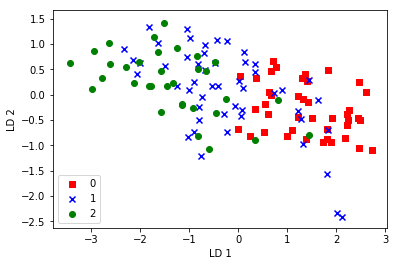

In [60]:
colors = ["r", "b", "g"]
markers = ["s", "x", "o"]

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0], X_train_lda[y_train == l, 1], c=c, label=l, marker=m)
plt.xlabel("LD 1")
plt.ylabel("LD 2")
plt.legend(loc="lower left")
plt.show()

## LDA via sckit-learn

In [62]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [63]:
lda = LDA(n_components=2).fit(X_train_std, y_train)

In [64]:
X_train_lda = lda.transform(X_train_std)

In [65]:
lr = LogisticRegression().fit(X_train_lda, y_train)

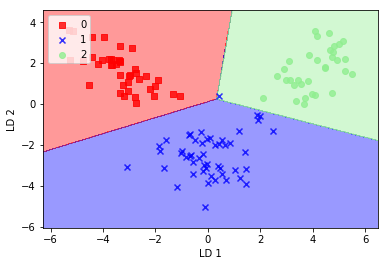

In [66]:
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel("LD 1")
plt.ylabel("LD 2")
plt.legend(loc="upper left")
plt.show()

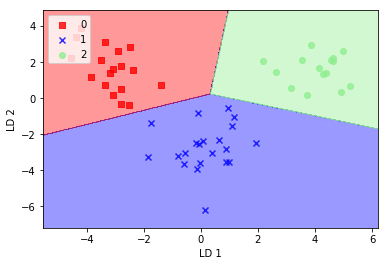

In [68]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel("LD 1")
plt.ylabel("LD 2")
plt.legend(loc="upper left")
plt.show()

## Using kernel principal component analysis for nonlinear mappings

In [3]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh

In [26]:
def rbf_kernel_pca(X, gamma, n_components):
    sq_dists = pdist(X, "sqeuclidean")
    mat_sq_dists = squareform(sq_dists)
    K = exp(-gamma * mat_sq_dists)
    N = K.shape[0]
    one_n = np.ones((N,N))/N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1,], eigvecs[:, ::-1]
    
    X_pc = np.column_stack((eigvecs[:, i] for i in range(n_components)))
    
    return X_pc

In [7]:
from sklearn.datasets import make_moons

In [8]:
X, y = make_moons(n_samples=100, random_state=123)

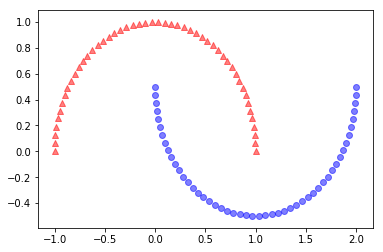

In [11]:
import matplotlib.pyplot as plt

plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", marker="^", alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", marker="o", alpha=0.5)
plt.show()

In [19]:
from sklearn.decomposition import PCA
import numpy as np

In [20]:
sckit_pca = PCA(n_components=2).fit(X)
X_spca = sckit_pca.transform(X)

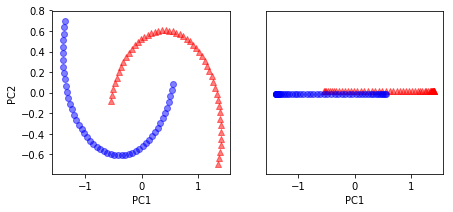

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1], color="red", marker="^", alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1], color="blue", marker="o", alpha=0.5)
ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02, color="red", marker="^", alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02, color="blue", marker="o", alpha=0.5)
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel("PC1")
plt.show()

In [27]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

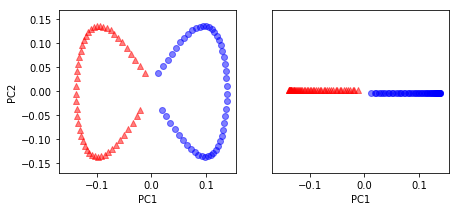

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1], color="red", marker="^", alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1], color="blue", marker="o", alpha=0.5)
ax[1].scatter(X_kpca[y == 0, 0], np.zeros((50, 1)) + 0.02, color="red", marker="^", alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((50, 1)) - 0.02, color="blue", marker="o", alpha=0.5)
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel("PC1")
plt.show()

In [29]:
from sklearn.datasets import make_circles

In [44]:
X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

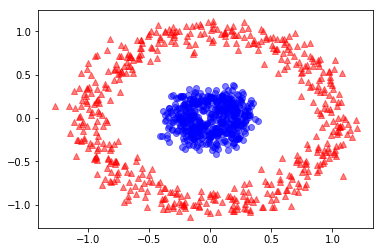

In [45]:
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", marker="^", alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", marker="o", alpha=0.5)
plt.show()

In [46]:
sckit_pca = PCA(n_components=2).fit(X)
X_spca = sckit_pca.transform(X)

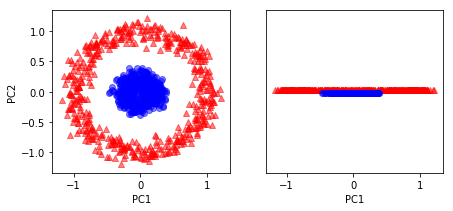

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1], color="red", marker="^", alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1], color="blue", marker="o", alpha=0.5)
ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02, color="red", marker="^", alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02, color="blue", marker="o", alpha=0.5)
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel("PC1")
plt.show()

In [48]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

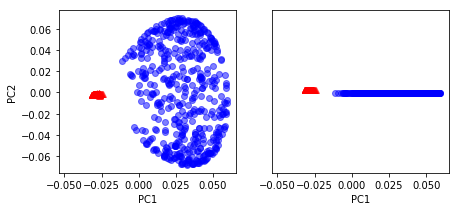

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1], color="red", marker="^", alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1], color="blue", marker="o", alpha=0.5)
ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02, color="red", marker="^", alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02, color="blue", marker="o", alpha=0.5)
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel("PC1")
plt.show()

### Projecting new data points